**Simple CNN**

In [1]:
os.getcwd()

NameError: name 'os' is not defined

In [5]:
%%time
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import EarlyStopping, TensorBoard
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator


# Data paths
train_data_dir = "/home/jupyter/images_gcs/Data/train"
test_data_dir = "/home/jupyter/images_gcs/Data/test"



# Image preprocessing
datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
train_generator = datagen.flow_from_directory(
    train_data_dir, target_size=(224, 224), batch_size=32, class_mode="categorical"
)
test_generator = datagen.flow_from_directory(
    test_data_dir, target_size=(224, 224), batch_size=32, class_mode="categorical"
)

# Build the CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),  # Convolutional layer with 32 filters and ReLU activation
    MaxPooling2D((2, 2)),  # Max pooling layer
    Conv2D(64, (3, 3), activation='relu'),  # Convolutional layer with 64 filters and ReLU activation
    MaxPooling2D((2, 2)),  # Max pooling layer
    Flatten(),  # Flatten layer
    Dense(len(train_generator.class_indices), activation='softmax')  # Output layer with softmax activation
])


# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1)

# Train the model
history = model.fit(train_generator, epochs=20, validation_data=test_generator, callbacks=[early_stopping, tensorboard])

# Predict labels for test set
y_pred = np.argmax(model.predict(test_generator), axis=-1)
y_true = test_generator.classes

# Calculate performance metrics
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Save the model
model.save("cnn_base_model_20ep.keras")

Found 5713 images belonging to 36 classes.
Found 1400 images belonging to 36 classes.
Epoch 1/20


2024-02-22 00:38:43.742538: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8900


149/179 [=======================>......] - ETA: 27s - loss: 3.7905 - accuracy: 0.0619

KeyboardInterrupt: 

In [10]:
from keras.models import load_model

# Load the saved model
loaded_model = load_model("cnn_base_model_20ep.keras")

# Display the model summary
loaded_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 186624)            0         
                                                                 
 dense_4 (Dense)             (None, 36)               

**Pulls Accuracy for Class**

44/44 [==============================] - 50s 1s/step


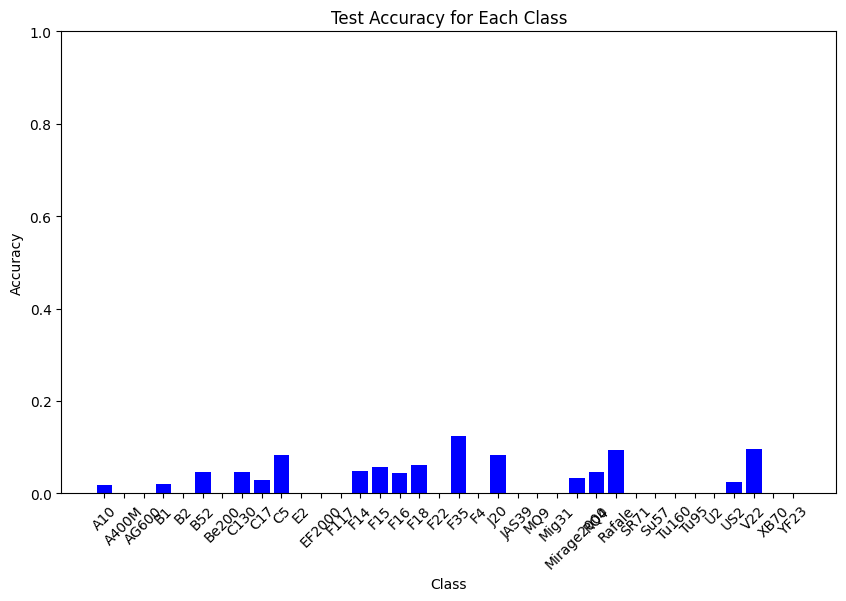

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

model = load_model("cnn_base_model.keras")

# Predict labels for test set
y_pred = np.argmax(model.predict(test_generator), axis=-1)
y_true = test_generator.classes

# Calculate accuracy for each class
class_labels = list(test_generator.class_indices.keys())
class_accuracy = []

for i, class_label in enumerate(class_labels):
    class_indices = np.where(np.array(y_true) == i)[0]
    class_pred = y_pred[class_indices]
    class_true = y_true[class_indices]
    class_accuracy.append(accuracy_score(class_true, class_pred))

# Plot the test accuracy for each class
plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_accuracy, color='blue')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Test Accuracy for Each Class')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()


**Paramater Info**

In [8]:
from keras.models import load_model

# Load the saved model
loaded_model = load_model("/content/drive/MyDrive/CNN_Model3")

# Display the model summary
loaded_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 49, 49, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 10, 10, 128)      

**Transfer Learning**

**Pre-trained with custom layer exactly the same as the best scratch model**

Need to change trage size in code below

In [7]:
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

def custom_block(model, filters, kernel_size, block_size):
    for _ in range(block_size):
        model.add(Conv2D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same', kernel_regularizer=L2(l2=0.01)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    return model

from keras.models import Sequential
from keras.callbacks import EarlyStopping, TensorBoard
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.regularizers import L2
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define TensorBoard callback
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1)

# Data paths
train_data_dir = "/home/jupyter/images_gcs/Data/train"
test_data_dir = "/home/jupyter/images_gcs/Data/test"
val_data_dir = "/home/jupyter/images_gcs/Data/val"

# Image preprocessing
datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
train_generator = datagen.flow_from_directory(
    train_data_dir, target_size=(224, 224), batch_size=32, class_mode="categorical", shuffle=True, seed=42
)
test_generator = datagen.flow_from_directory(
    test_data_dir, target_size=(224, 224), batch_size=32, class_mode="categorical", shuffle=False
)
val_generator = datagen.flow_from_directory(
    val_data_dir, target_size=(224, 224), batch_size=32, class_mode="categorical", shuffle=False
)



Found 5713 images belonging to 36 classes.
Found 1400 images belonging to 36 classes.
Found 1420 images belonging to 36 classes.


In [ ]:
# Create the model
model = Sequential()

# Load the EfficientNetB3 model pre-trained on ImageNet without the top (classification) layer
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Add Block 1
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=L2(l2=0.01), input_shape=(224, 224, 3)))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=L2(l2=0.01)))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=L2(l2=0.01)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

# Add Block 2
model = custom_block(model, filters=128, kernel_size=(3,3), block_size=3)

# Add Block 3
model = custom_block(model, filters=256, kernel_size=(3,3), block_size=3)

# Add Block 4
model = custom_block(model, filters=512, kernel_size=(3,3), block_size=3)

# Dense
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

# Softmax
model.add(Dense(len(train_generator.class_indices), activation='softmax'))

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(0.00004),
    metrics=['accuracy']
)

# Fit the model
history = model.fit(train_generator,
                    workers=8,
                    epochs=50, 
                    validation_data=val_generator, 
                    callbacks=[early_stopping, tensorboard])

# Plot training history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(val_generator)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate performance metrics for validation set
val_pred = np.argmax(model.predict(val_generator), axis=-1)
val_true = val_generator.classes

val_precision = precision_score(val_true, val_pred, average='weighted')
val_recall = recall_score(val_true, val_pred, average='weighted')
val_f1 = f1_score(val_true, val_pred, average='weighted')

print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)
print("Validation F1 Score:", val_f1)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Predict labels for the test set
y_pred = np.argmax(model.predict(test_generator), axis=-1)
y_true = test_generator.classes

# Calculate performance metrics for the test set
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", f1)

# Save the model
model.save("EfficientNetB0_Model.keras")


2024-02-21 23:54:02.490877: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8900


44/44 [==============================] - 17s 341ms/step


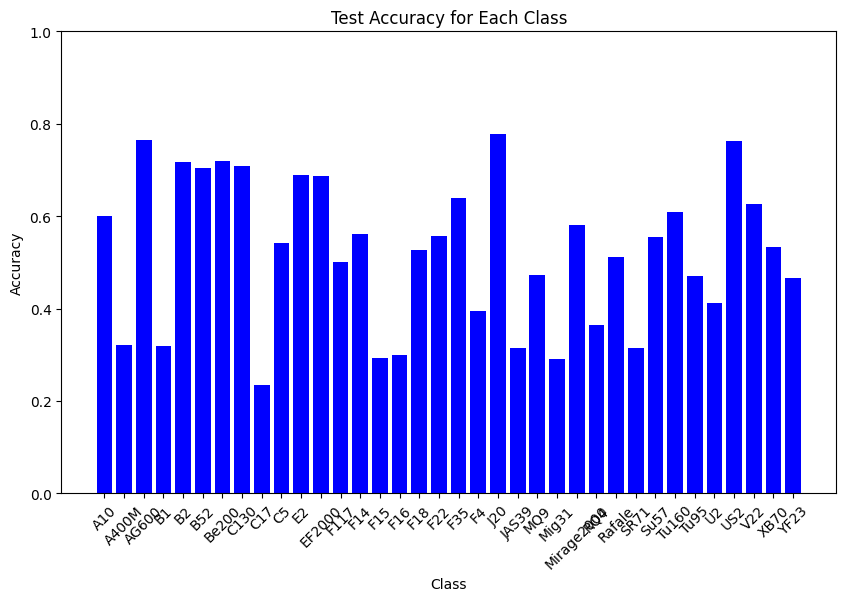

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from keras.models import load_model


model = load_model("EfficientNetB0_Model.keras")

# Predict labels for test set
y_pred = np.argmax(model.predict(test_generator), axis=-1)
y_true = test_generator.classes

# Calculate accuracy for each class
class_labels = list(test_generator.class_indices.keys())
class_accuracy = []

for i, class_label in enumerate(class_labels):
    class_indices = np.where(np.array(y_true) == i)[0]
    class_pred = y_pred[class_indices]
    class_true = y_true[class_indices]
    class_accuracy.append(accuracy_score(class_true, class_pred))

# Plot the test accuracy for each class
plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_accuracy, color='blue')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Test Accuracy for Each Class')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()


In [5]:
accuracy_score(y_pred, y_true)

0.5228571428571429

In [13]:
from keras.models import load_model

loaded_model = load_model("EfficientNetB0_Model.keras")

# Display the model summary
loaded_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_37 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 conv2d_38 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 batch_normalization_12 (Bat  (None, 112, 112, 64)     256       
 chNormalization)                                                
                                                                 
 conv2d_39 (Conv2D)          (None, 112, 112, 128)    

## B7 Attempt

Found 5713 images belonging to 36 classes.
Found 1400 images belonging to 36 classes.
Found 1420 images belonging to 36 classes.
Epoch 1/50
179/179 [==============================] - ETA: 0s - loss: 28.7689 - accuracy: 0.0604

2024-02-21 23:55:30.091422: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 12331253760 exceeds 10% of free system memory.


179/179 [==============================] - 49s 252ms/step - loss: 28.7689 - accuracy: 0.0604 - val_loss: 28.5831 - val_accuracy: 0.0310
Epoch 2/50
179/179 [==============================] - ETA: 0s - loss: 27.8278 - accuracy: 0.0938

2024-02-21 23:56:13.116110: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 12331253760 exceeds 10% of free system memory.


179/179 [==============================] - 43s 237ms/step - loss: 27.8278 - accuracy: 0.0938 - val_loss: 28.1366 - val_accuracy: 0.0444
Epoch 3/50
179/179 [==============================] - ETA: 0s - loss: 26.9824 - accuracy: 0.1201

2024-02-21 23:56:55.475559: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 12331253760 exceeds 10% of free system memory.


179/179 [==============================] - 42s 233ms/step - loss: 26.9824 - accuracy: 0.1201 - val_loss: 26.7672 - val_accuracy: 0.0789
Epoch 4/50
179/179 [==============================] - ETA: 0s - loss: 26.0505 - accuracy: 0.1631

2024-02-21 23:57:37.634053: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 12331253760 exceeds 10% of free system memory.


179/179 [==============================] - 42s 233ms/step - loss: 26.0505 - accuracy: 0.1631 - val_loss: 25.6957 - val_accuracy: 0.1570
Epoch 5/50
179/179 [==============================] - ETA: 0s - loss: 25.1025 - accuracy: 0.2016

2024-02-21 23:58:21.369536: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 12331253760 exceeds 10% of free system memory.


179/179 [==============================] - 43s 238ms/step - loss: 25.1025 - accuracy: 0.2016 - val_loss: 24.7232 - val_accuracy: 0.1915
Epoch 6/50
179/179 [==============================] - 43s 236ms/step - loss: 24.1777 - accuracy: 0.2370 - val_loss: 23.9660 - val_accuracy: 0.1972
Epoch 7/50
179/179 [==============================] - 43s 239ms/step - loss: 23.2131 - accuracy: 0.2794 - val_loss: 22.9469 - val_accuracy: 0.2718
Epoch 8/50
179/179 [==============================] - 43s 239ms/step - loss: 22.2775 - accuracy: 0.3278 - val_loss: 22.2881 - val_accuracy: 0.2986
Epoch 9/50
179/179 [==============================] - 44s 241ms/step - loss: 21.3653 - accuracy: 0.3858 - val_loss: 21.3183 - val_accuracy: 0.3162
Epoch 10/50
179/179 [==============================] - 44s 244ms/step - loss: 20.4627 - accuracy: 0.4267 - val_loss: 20.5195 - val_accuracy: 0.3634
Epoch 11/50
179/179 [==============================] - 45s 246ms/step - loss: 19.5925 - accuracy: 0.4752 - val_loss: 19.9086 - v

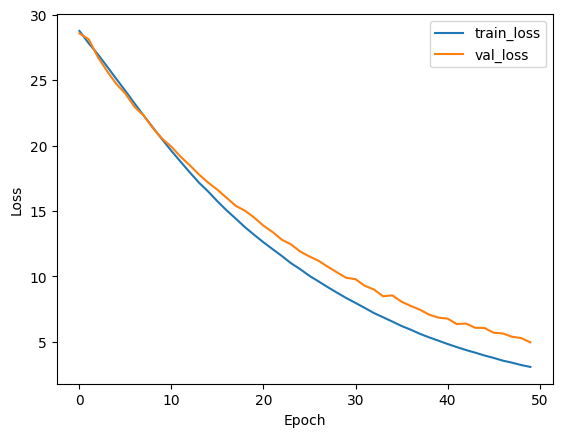

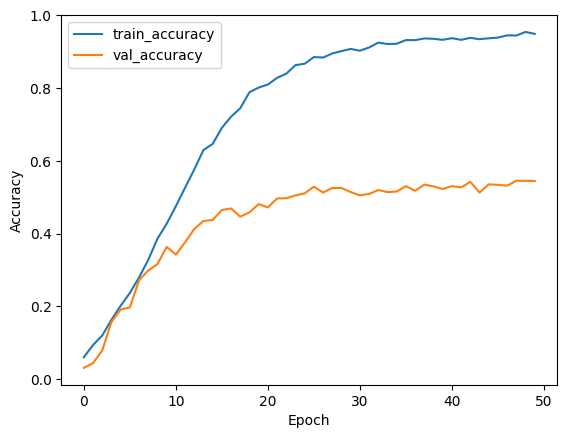

45/45 [==============================] - 16s 346ms/step - loss: 4.9228 - accuracy: 0.5479
Validation Loss: 4.92280912399292
Validation Accuracy: 0.5478873252868652
45/45 [==============================] - 15s 339ms/step
Validation Precision: 0.5861845889990385
Validation Recall: 0.5528169014084507
Validation F1 Score: 0.5558028657992793
44/44 [==============================] - 46s 1s/step - loss: 4.9992 - accuracy: 0.5386
Test Loss: 4.999244689941406
Test Accuracy: 0.5385714173316956
44/44 [==============================] - 15s 340ms/step
Test Precision: 0.5536394342347155
Test Recall: 0.5292857142857142
Test F1 Score: 0.5278527210821112


In [ ]:
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

def custom_block(model, filters, kernel_size, block_size):
    for _ in range(block_size):
        model.add(Conv2D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same', kernel_regularizer=L2(l2=0.01)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    return model

from keras.models import Sequential
from keras.callbacks import EarlyStopping, TensorBoard
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.regularizers import L2
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define TensorBoard callback
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1)

# Data paths
train_data_dir = "/home/jupyter/images_gcs/Data/train"
test_data_dir = "/home/jupyter/images_gcs/Data/test"
val_data_dir = "/home/jupyter/images_gcs/Data/val"

# Image preprocessing
datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
train_generator = datagen.flow_from_directory(
    train_data_dir, target_size=(224, 224), batch_size=32, class_mode="categorical", shuffle=True, seed=42
)
test_generator = datagen.flow_from_directory(
    test_data_dir, target_size=(224, 224), batch_size=32, class_mode="categorical", shuffle=False
)
val_generator = datagen.flow_from_directory(
    val_data_dir, target_size=(224, 224), batch_size=32, class_mode="categorical", shuffle=False
)

# Create the model
model = Sequential()

# Load the EfficientNetB3 model pre-trained on ImageNet without the top (classification) layer
base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Add Block 1
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=L2(l2=0.01), input_shape=(224, 224, 3)))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=L2(l2=0.01)))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=L2(l2=0.01)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

# Add Block 2
model = custom_block(model, filters=128, kernel_size=(3,3), block_size=3)

# Add Block 3
model = custom_block(model, filters=256, kernel_size=(3,3), block_size=3)

# Add Block 4
model = custom_block(model, filters=512, kernel_size=(3,3), block_size=3)

# Dense
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

# Softmax
model.add(Dense(len(train_generator.class_indices), activation='softmax'))

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(0.00004),
    metrics=['accuracy']
)

# Fit the model
history = model.fit(train_generator,
                    workers=6,
                    epochs=50, 
                    validation_data=val_generator, 
                    callbacks=[early_stopping, tensorboard])

# Plot training history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(val_generator)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Calculate performance metrics for validation set
val_pred = np.argmax(model.predict(val_generator), axis=-1)
val_true = val_generator.classes

val_precision = precision_score(val_true, val_pred, average='weighted')
val_recall = recall_score(val_true, val_pred, average='weighted')
val_f1 = f1_score(val_true, val_pred, average='weighted')

print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)
print("Validation F1 Score:", val_f1)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Predict labels for the test set
y_pred = np.argmax(model.predict(test_generator), axis=-1)
y_true = test_generator.classes

# Calculate performance metrics for the test set
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", f1)

# Save the model
model.save("EfficientNetB7_Model.keras")


44/44 [==============================] - 42s 967ms/step


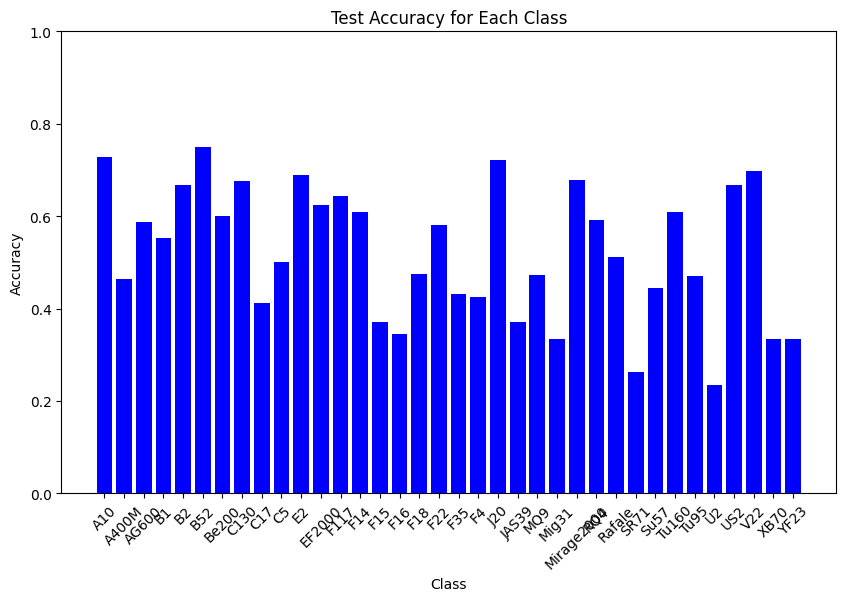

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from keras.models import load_model


model = load_model("EfficientNetB7_Model.keras")

# Predict labels for test set
y_pred = np.argmax(model.predict(test_generator), axis=-1)
y_true = test_generator.classes

# Calculate accuracy for each class
class_labels = list(test_generator.class_indices.keys())
class_accuracy = []

for i, class_label in enumerate(class_labels):
    class_indices = np.where(np.array(y_true) == i)[0]
    class_pred = y_pred[class_indices]
    class_true = y_true[class_indices]
    class_accuracy.append(accuracy_score(class_true, class_pred))

# Plot the test accuracy for each class
plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_accuracy, color='blue')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Test Accuracy for Each Class')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()


## ResNet50

In [8]:
# Image preprocessing
datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
train_generator = tf.keras.utils.image_dataset_from_directory(
    train_data_dir, image_size=(224, 224), batch_size=32, labels="inferred", shuffle=True, seed=42
)
test_generator = tf.keras.utils.image_dataset_from_directory(
    test_data_dir, image_size=(224, 224), batch_size=32, labels="inferred", shuffle=False
)
val_generator = tf.keras.utils.image_dataset_from_directory(
    val_data_dir, image_size=(224, 224), batch_size=29, labels="inferred", shuffle=False
)

Found 5713 files belonging to 36 classes.
Found 1400 files belonging to 36 classes.
Found 1420 files belonging to 36 classes.


In [10]:
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

import tensorflow as tf
from keras.models import Sequential
from keras.callbacks import EarlyStopping, TensorBoard
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.regularizers import L2
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

# Feature extraction layer
# (a) Input processing
preprocess_input = resnet50.preprocess_input

# (b) create base model using ResNet50

base_model = ResNet50(input_shape=(224,224,3),
                                   include_top=False,
                                   weights='imagenet')

# (c) Freeze layers
base_model.trainable = False
base_model.summary()

# (d) Classification layer
nClass = len(train_generator.class_names)

global_avg = GlobalAveragePooling2D()
output_layer = Dense(nClass, activation='softmax')

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [11]:
# Create prefetch for train,test,val data
AUTOTUNE = tf.data.AUTOTUNE
pf_train = train_generator.prefetch(buffer_size=AUTOTUNE)
pf_test = test_generator.prefetch(buffer_size=AUTOTUNE)
pf_val = val_generator.prefetch(buffer_size=AUTOTUNE)

In [12]:
from tensorflow.keras import optimizers, losses, layers


In [13]:
# Augmentation layer
data_augmentation = tf.keras.Sequential()
data_augmentation.add(layers.RandomFlip('horizontal_and_vertical'))
data_augmentation.add(layers.RandomRotation(0.4))

In [14]:
import tensorflow as tf

inputs = tf.keras.Input(shape=(224,224,3))
x = preprocess_input(inputs)
x = data_augmentation(inputs)
x = base_model(x)
x = global_avg(x)
outputs = output_layer(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_1 (Dense)             (None, 36)                73764     
                                                                 
Total params: 23,661,476
Trainable params: 73,764
Non-trainable params: 23,587,712
____________________________________________

In [18]:
from tensorflow.keras import optimizers, losses, layers
# Compile model
lr_schedule = optimizers.schedules.CosineDecay(0.001, 500)
optimizer = optimizers.Adam(learning_rate=lr_schedule)
loss = losses.SparseCategoricalCrossentropy()

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [19]:
# Train Model
EPOCHS = 5
history = model.fit(train_generator,
                    workers=6,
                    validation_data=val_generator, 
                    epochs=EPOCHS)

Epoch 1/5
179/179 [==============================] - 49s 250ms/step - loss: 2.9881 - accuracy: 0.2078 - val_loss: 2.5449 - val_accuracy: 0.3099
Epoch 2/5
179/179 [==============================] - 38s 208ms/step - loss: 2.2112 - accuracy: 0.3867 - val_loss: 2.2852 - val_accuracy: 0.3711
Epoch 3/5
179/179 [==============================] - 38s 210ms/step - loss: 1.9983 - accuracy: 0.4504 - val_loss: 2.2517 - val_accuracy: 0.3796
Epoch 4/5
179/179 [==============================] - 38s 208ms/step - loss: 1.9690 - accuracy: 0.4658 - val_loss: 2.2517 - val_accuracy: 0.3796
Epoch 5/5
179/179 [==============================] - 38s 205ms/step - loss: 1.9637 - accuracy: 0.4635 - val_loss: 2.2517 - val_accuracy: 0.3796


## Let's Fine Tune Model

In [20]:
# Finetune layer of base model
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

# Recompile model
optimizer = optimizers.RMSprop(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [21]:
# Continue model training
fine_tune_epoch = 2
NEW_EPOCH = EPOCHS + fine_tune_epoch

history_fine = model.fit(pf_train,
                         validation_data=(pf_val),
                         epochs=NEW_EPOCH,
                         initial_epoch=history.epoch[-1])

Epoch 5/7
179/179 [==============================] - 54s 230ms/step - loss: 2.6161 - accuracy: 0.3144 - val_loss: 3.6232 - val_accuracy: 0.2155
Epoch 6/7
179/179 [==============================] - 42s 229ms/step - loss: 1.3248 - accuracy: 0.6174 - val_loss: 1.2332 - val_accuracy: 0.6415
Epoch 7/7
179/179 [==============================] - 41s 223ms/step - loss: 0.7282 - accuracy: 0.7928 - val_loss: 1.0510 - val_accuracy: 0.7021


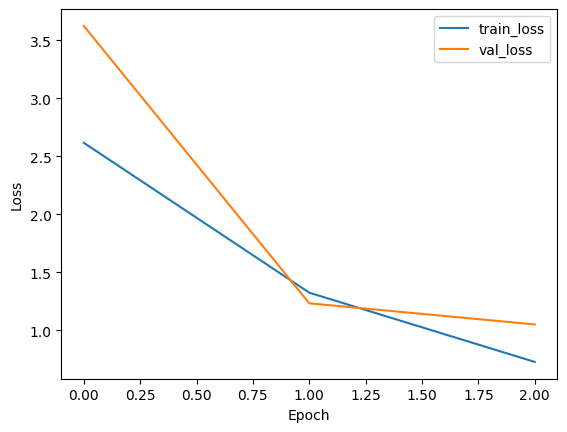

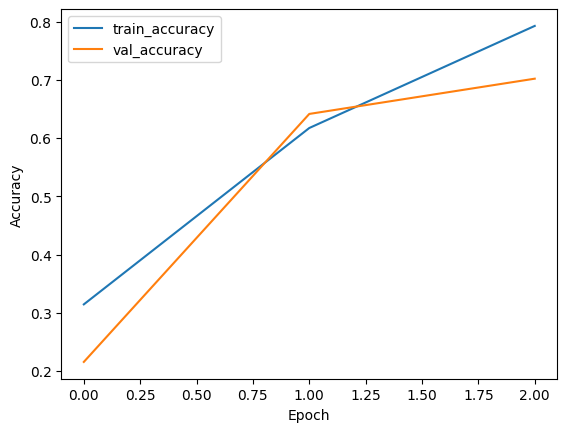

In [23]:
# Plot training history
plt.plot(history_fine.history['loss'], label='train_loss')
plt.plot(history_fine.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history_fine.history['accuracy'], label='train_accuracy')
plt.plot(history_fine.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



# Save the model
model.save("ResNet50_Model.keras")


In [24]:
test_loss, test_accuracy = model.evaluate(pf_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

44/44 [==============================] - 27s 607ms/step - loss: 1.0670 - accuracy: 0.6871
Test Loss: 1.0669976472854614
Test Accuracy: 0.6871428489685059


In [25]:
test_label = np.concatenate([y for x, y in pf_test], axis=0) 


In [26]:
# Predict labels for test set
y_pred = np.argmax(model.predict(test_generator), axis=-1)
y_true = test_label

44/44 [==============================] - 2s 33ms/step


A10
A400M
AG600
B1
B2
B52
Be200
C130
C17
C5
E2
EF2000
F117
F14
F15
F16
F18
F22
F35
F4
J20
JAS39
MQ9
Mig31
Mirage2000
RQ4
Rafale
SR71
Su57
Tu160
Tu95
U2
US2
V22
XB70
YF23


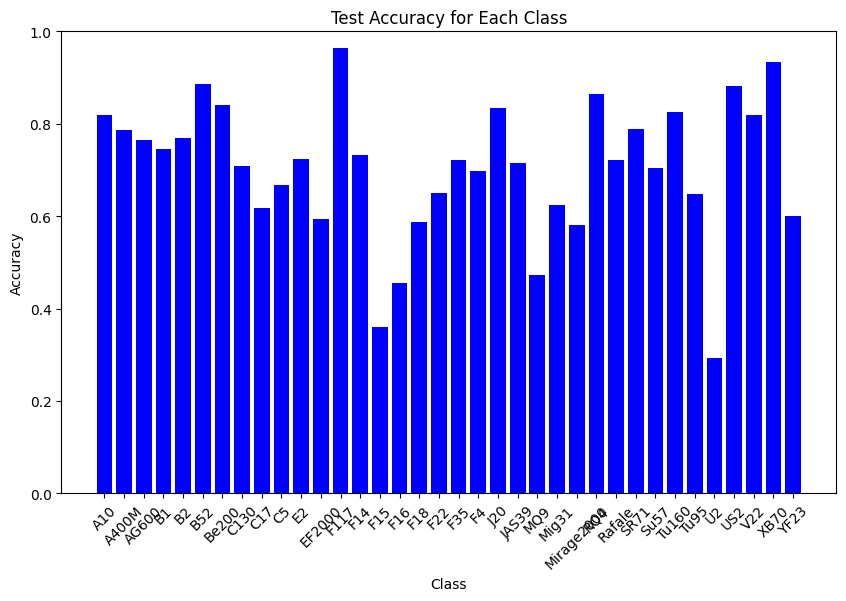

In [27]:
# Calculate accuracy for each class
class_labels = list(test_generator.class_names)
class_accuracy = []

for i, class_label in enumerate(class_labels):
    print(class_label)
    class_indices = np.where(np.array(y_true) == i)[0]
    class_pred = y_pred[class_indices]
    class_true = y_true[class_indices]
    class_accuracy.append(accuracy_score(class_true, class_pred))

# Plot the test accuracy for each class
plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_accuracy, color='blue')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Test Accuracy for Each Class')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()